# Neural feature selection

In [9]:
# Import libraries
import numpy as np
import aopy
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as fm
import time
from importlib import reload



from db import dbfunctions as db

import seaborn as sns
from scipy import signal
import scipy

from aopy.analysis import KFDecoder
import collections
import cvxpy as cp
import pickle
import random

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  GridSearchCV
from sklearn.linear_model import Lasso

from sklearn.metrics import r2_score


# import feature_selection_functions
# from feature_selection_feature import JointConvexFeatureSelector, LassoFeatureSelector

# from feature_selection_functions import *
# from ECoG_plotting import *
# from weights import *  

import seaborn as sns
sns.set_context('paper')

# Update default Matplotlib settings to remove top and right spines
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False


NUM_FREQ_BANDS, NUM_ELECTRODES  = 5,  236

This notebook shows examples of how to select neural features using lasso feature selection. 

In [2]:
# define the band index, and the frequency bands
delta = ( 0,4 )
theta = (4,10)
alpha = (8,12) # this is not used yet
beta = (12,30)
gamma =(30,80) 
high_gamma = (80,150)
lfp_bands = [delta, theta, beta, gamma, high_gamma]
band_names = ["Delta", "Theta", "Beta", "Gamma", "High Gamma"]

# build a dictionary of the frequency bands and its index
band_dict = collections.OrderedDict()
for i, band in enumerate(band_names):band_dict[band] = i

# load the channel map
# TODO: clean up the code and turn this into a config file
acq_ch_locations, acq_ch, connected_elecs = aopy.data.load_chmap()
custom_electrodes = np.arange(1, 241) # 1-indexed
connected_custom_electrodes = np.isin(connected_elecs,  custom_electrodes)
channels = acq_ch[connected_custom_electrodes]-1 
# find index if its true 
channels_pos = acq_ch_locations[connected_custom_electrodes]

In [10]:
results_dir = "feature_selection_example_data"
data_files = ['neural_dat_train.pkl', 'cursor_dat_train.pkl', 
              'neural_dat_test.pkl', 'cursor_dat_test.pkl']

loaded_data = []

for file_temp in data_files:
    with open(os.path.join(results_dir, file_temp), 'rb') as f:
        d = pickle.load(f, encoding='latin1')
        loaded_data.append(d.copy())

[neural_dat_train, cursor_dat_train,\
    neural_dat_test, cursor_dat_test] = loaded_data

# print out the shapes

print(neural_dat_train.shape, cursor_dat_train.shape,
      neural_dat_test.shape, cursor_dat_test.shape)

# we need to reshape the arrays 
if neural_dat_train.ndim == 3:
    neural_dat_train = neural_dat_train.reshape(neural_dat_train.shape[0], -1)
    neural_dat_test = neural_dat_test.reshape(neural_dat_test.shape[0], -1)
    
print(neural_dat_train.shape, cursor_dat_train.shape)

(4348, 1180) (4348, 2) (2117, 1180) (2117, 2)
(4348, 1180) (4348, 2)


# Feature selection algorithms

## Lasso feature selection algorithm

In [11]:
def lasso_main(neural_dat_train,
               neural_dat_test,
               cursor_dat_train,cursor_dat_test,
               model_alphas = np.arange(0.1,10,0.1),
               do_predictions = False, 
               return_coef = False):
    
    print("Data length", len(neural_dat_train))
    # get the importance coefficients
    pipeline = Pipeline([
        ('scaler',StandardScaler()), # part of normalizing
        ('model',Lasso())
    ])   
    search = GridSearchCV(pipeline,
                     {'model__alpha': model_alphas},
                     cv = 5,
                     scoring="neg_mean_squared_error")
    
    search.fit(neural_dat_train,cursor_dat_train)
    
    coefficients = search.best_estimator_.named_steps['model'].coef_
    
    importance = np.abs(coefficients)
    
    coef = np.zeros(importance.shape[1])

    for i in range(importance.shape[1]):
        if importance[:,i].any() > 0:
            coef[i] = 1

    coef = np.asarray(coef,dtype=bool)


    if do_predictions:
        # train & test kf with "important" features
        kf = KFDecoder(C=1)
        kf.fit(neural_dat_train[:,coef],cursor_dat_train)
        pred = kf.predict(neural_dat_test[:,coef],cursor_dat_test)
    else:
        pred = 0
    
    if return_coef:
        return coef,pred,importance

    return coef,pred

In [12]:
model_alphas = np.array([0.04]) # one grid value takes about a few second
active_set_all_lasso,lasso_pred = \
    lasso_main(neural_dat_train,neural_dat_test,
                            cursor_dat_train,cursor_dat_test,
                            model_alphas= model_alphas,
                            do_predictions = False)

Data length 4348


In [13]:
def get_selected_unselected_electrodes(active_set, 
                                       frequency_band, 
                                       num_freq_bands, num_electrodes):
    """
    Given an active set and a frequency band, returns the selected and unselected electrodes.

    Parameters:
    - active_set: numpy array of shape (num_freq_bands * num_electrodes,) representing the active set.
    - frequency_band: integer, index of the frequency band.
    - num_freq_bands: integer, number of frequency bands.
    - num_electrodes: integer, number of electrodes.

    Returns:
    - selected_electrodes: numpy array of indices of the selected electrodes.
    - unselected_electrodes: numpy array of indices of the unselected electrodes.
    """
    active_set_band_by_electrode = active_set.reshape(num_freq_bands, num_electrodes)
    assert active_set_band_by_electrode.shape == (num_freq_bands, num_electrodes)

    selected_electrodes = np.where(active_set_band_by_electrode[frequency_band] == 1)[0]
    unselected_electrodes = np.where(active_set_band_by_electrode[frequency_band] == 0)[0]

    return selected_electrodes, unselected_electrodes

def plot_electrode_selection(channels_pos, selected_electrodes, unselected_electrodes, 
                    ax=None, 
                    band_name = "", 
                    show_legend=True, add_scale_bar=True):
    """
    Plots the electrode positions with selected and unselected electrodes.

    Parameters:

    - channels_pos: numpy array of shape (n_channels, 2) with the positions of the electrodes.
    - selected_electrodes: list or array of indices of the selected electrodes.
    - unselected_electrodes: list or array of indices of the unselected electrodes.
    - ax: matplotlib axes object where the plot will be drawn. If None, a new figure and axes will be created.
    - band_name: string, name of the frequency band.
    - show_legend: boolean, whether to show the legend.
    - add_scale_bar: boolean, whether to add a scale bar.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    # plot the selected electrodes using a solid square
    ax.plot(channels_pos[selected_electrodes, 0], 
            channels_pos[selected_electrodes, 1], "s", 
            c='black')

    # plot the unselected electrodes using a hollow square
    ax.plot(channels_pos[unselected_electrodes, 0], 
            channels_pos[unselected_electrodes, 1], "s",
            c='black',
            markerfacecolor='none',
            markeredgecolor='black')

    # make legend that solid square is selected and hollow square is unselected
    if show_legend:
        ax.legend(['Selected', 'Unselected'], 
                  loc='upper center', 
                  bbox_to_anchor=(0.5, -0.01), ncol=2,
                  frameon=False)

    ax.set_title(f' {band_name}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')

    # Remove the plot boundary
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Remove the x and y scale markers
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a scale bar
    if add_scale_bar: 
        fontprops = fm.FontProperties(size=10)
        scalebar = AnchoredSizeBar(ax.transData,
                                   1, '1 mm', 'lower left', 
                                   pad=0.1,
                                   color='black',
                                   frameon=False,
                                   size_vertical=0.1,
                                   fontproperties=fontprops)
        ax.add_artist(scalebar)

    if ax is None:
        plt.show()
    
    return ax

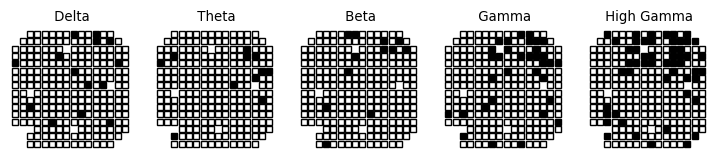

In [14]:
# make 5 subplots for each frequency band in two rows
fig, axs = plt.subplots(1, 5, figsize=(9, 1.8))

for i, band_name in enumerate(band_names):
    frequency_band = band_dict[band_name]

    selected_electrodes, unselected_electrodes = \
        get_selected_unselected_electrodes(
        active_set_all_lasso, frequency_band, 
        NUM_FREQ_BANDS, NUM_ELECTRODES)
    
    ax = axs[i]
    plot_electrode_selection(channels_pos, selected_electrodes, unselected_electrodes, 
                             ax=ax, band_name=band_name, 
                             show_legend=False,
                             add_scale_bar=False)